# The design principles of `eensight`

In [1]:
import matplotlib.pyplot as plt

from eensight.utils import load_catalog

plt.style.use("bmh")

%matplotlib inline

## Installation

`eensight` can be installed by pip:

```bash
pip install eensight
```

## Namespaces

There are three (3) namespaces in `eensight`: 

* `train`: Datasets and pipelines that exist in the `train` namespace will be used for baseline model training.

* `test`: Datasets and pipelines that exist in the `test` namespace will be used for baseline model evaluation. 

* `apply`: Datasets and pipelines that exist in the `apply` namespace will be used for counterfactual prediction (the reporting period).

This means that, by convention, there should be no difference between `train` and `test` data. If an event that alters the characteristics of the energy consumption (such as an energy retrofit) has taken place, the post-event data should be in the `apply` namespace. 

## Pipelines

All the functionality in `eensight` is organized around data pipelines. Each pipeline consumes data and other artifacts (such as models) produced by a previous pipeline, and produces new data and artifacts for its successor pipelines.

There are four (4) pipelines in `eensight`. The names of the pipelines and the associations between pipelines and namespaces are summarized below:

|            	| train    	| test   	| apply   |
|------------	|----------	|----------	|---------|
| preprocess 	| &#10004; 	| &#10004; 	| &#10004;|
| predict    	| &#10004; 	| &#10004;	| &#10004;|
| evaluate    	|          	| &#10004;  | &#10004;|
| adjust    	|          	|           | &#10004;|

The next chapters will explain in detail the functionality of each pipeline.

The primary way of using `eensight` is through the command line. The first argument is always the name of the pipeline to run, such as:

```bash
eensight run predict
```

The command

```bash
eensight run all
```

will run pipelines one after the other, while the command

```bash
eensight run default
```
will run only the `preprocess` and `predict` pipelines.

## Input data

There are four (4) arguments that affect where `eensight` searches for the input data, and where it stores all intermediate and final results:

`--site-id`: The id or name of the building site. This enables path configurations that include the site id to differentiate between different datasets.

`--store-uri`: The URI where the generated data and models should be stored. If not provided, `eensigh` will search for an `EENSIGHT_STORE_URI` environmemt variable.

`--input-uri`: The URI where the input data can be found. If provided, the input features are expected to be found at `{{ input_uri }}/{{ namespace }}/features` and the input labels at `{{ input_uri }}/{{ namespace }}/labels`. If not provided, `eensight` will use `{{ store_uri }}/{{ site_id }}/01_raw/{{ namespace }}/features` path as default for the input features and `{{ store_uri }}/{{ site_id }}/01_raw/{{ namespace }}/labels` for the input labels.

`--batch`: The batch id for the input data (features and labels) to apply the pipelines on. In `eensight`, training and testing of pipelines (`train` and `test` namespaces) is done on specific
datasets, but applying the pipelines (`apply` namespace) can be done on different batches of the data. If `batch` is provided, the input data is expected to be inside a `.../apply/{{ batch }}/features` path for features and `.../apply/{{ batch }}/labels` for labels.

## Data catalog

All pipelines get and store their datasets, parameters and models by interacting with a [data catalog](https://kedro.readthedocs.io/en/stable/data/data_catalog.html):

![Catalog](../../images/catalog.png)

The catalog is parameterized by the following arguments that can be passed to the command line when running `eensight`:

<code>--site-id</code>: The id or name of the building site.


<code>--namespace</code>: The namespace acts as a prefix to the artifacts in the catalog.

The function `eensight.utils.load_catalog` allows loading the `eensight` catalog while parameterizing it for the `site_id` and the `namespace`. As an example, we can load the `train` data of the *b01* dataset. The *b01* dataset corresponds to the building with `id=4` of the dataset provided by the [EnergyDetective 2020](https://zenodo.org/record/6590976) competition. 

In [5]:
catalog_train = load_catalog(store_uri="../../data", site_id="b01", namespace="train")

The contents of the parameterized catalog are:

In [6]:
catalog_train.list()

[
    'model',
    'model-autoenc',
    'train.input-features',
    'train.input-labels',
    'train.validated-features',
    'train.validated-labels',
    'train.preprocessed-features',
    'train.preprocessed-labels',
    'train.adequacy-summary',
    'train.prediction',
    'train.prediction-autoenc',
    'train.activity',
    'train.performance',
    'train.performance-autoenc',
    'parameters',
    'app',
    'params:activity',
    'params:activity.non_occ_features',
    'params:activity.cat_features',
    'params:activity.exog',
    'params:activity.assume_hurdle',
    'params:activity.n_trials',
    'params:activity.n_trials_adjust',
    'params:activity.upper_bound',
    'params:activity.verbose',
    'params:fit',
    'params:fit.lags',
    'params:fit.lags.temperature',
    'params:fit.cat_features',
    'params:fit.validation_size',
    'params:rebind_names',
    'params:rebind_names.consumption',
    'params:rebind_names.temperature',
    'params:rebind_names.timestamp',
    'params:date_format',
    'params:adequacy',
    'params:adequacy.max_missing_pct',
    'params:validation',
    'params:validation.threshold',
    'params:alignment',
    'params:alignment.mode',
    'params:alignment.mode.temperature',
    'params:alignment.tolerance',
    'params:alignment.tolerance.temperature',
    'params:alignment.cumulative',
    'params:alignment.cumulative.temperature',
    'params:alignment.cumulative.consumption',
    'params:filter',
    'params:filter.min_value',
    'params:filter.max_value',
    'params:filter.allow_zero',
    'params:filter.allow_negative'
]

The catalog provides access to the stored artifacts:

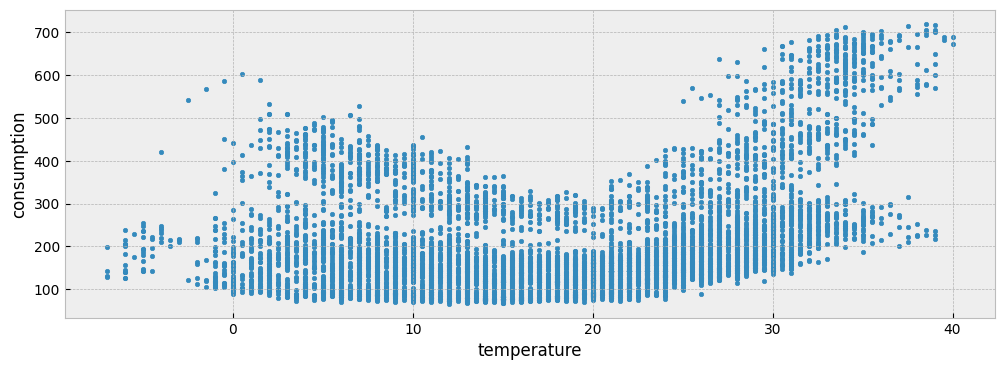

In [7]:
X_train = catalog_train.load("train.preprocessed-features")
y_train = catalog_train.load("train.preprocessed-labels")

fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.scatter(X_train["temperature"], y_train["consumption"], s=10)
ax.set_xlabel("temperature")
ax.set_ylabel("consumption")

Artifacts that start with the namespace, such as the `train.input-features`, are accesible only when `eensight` runs with the specific namespace, for instance:

```bash
eensight run predict --namespace train
```

Artifacts without a namespace, such as the `model`, are accesible by all pipelines irrespectively of the selected namespace. The same is true for all parameters.

## Parameter values

`eensight` pipelines get their parameter settings from YAML files in the *conf/base/parameters* directory.

```
conf
│   README.md 
│
└───base
│   │   catalog.yml
|   |   globals.yml
│   │   logging.yml
│   │
│   └── parameters
│       ├── preprocess.yml
│       ├── predict.yml
   
```

Parameters are accessed and treated exactly as prescribed by the Kedro documentation: https://kedro.readthedocs.io/en/stable/kedro_project_setup/configuration.html#parameters

The values of the parameters can be changed from the command line. As an example, the default value of the `activity.assume_hurdle` parameter is:

In [8]:
catalog.load("params:activity.assume_hurdle")

False

It can be changed to `True` by passing the following option to the command line:

```bash
eensight run predict --param activity.assume_hurdle=true
```

## Experiment tracking

`eensight` uses [MLflow](https://www.mlflow.org/) for experiment tracking. By default, MLflow tracking is enabled, which means: (a) all runs get a unique id (run_id), (b) all artifacts generated by a run are saved in a `{{ store_uri }}/{{ site_id }}/tracked/{{ run_id }}/` path, and (c) all
parameters and metrics are stored by the MLflow tracking server. If disabled, (a) runs do not
get a run_id, (b) all artifacts generated are saved in a `{{ store_uri }}/{{ site_id }}/untracked/`
path, and (c) parameters and metrics are not stored by MLflow. If namespace is `apply`, MLflow
tracking is disabled automatically.

Experiment tracking can be disabled by passing the `--no-tracking` flag to the command line:

```bash
eensight run predict --site-id b01 --namespace train --no-tracking
```

The generated run id can be passed to the command line as well:

```bash
eensight run predict --site-id b01 --namespace train --run-id 6fa459eaee8a3ca4
```

Passing the run id indicates to `eensight` the run that contains the artifacts to be used (by `test` and `apply` pipelines) or updated (by `train` pipelines). If not provided and namespace is `train` and MLflow tracking is enabled, a new run id will be created. If not provided and namespace is `test`
or `apply`, the untracked artifacts will be used.

The command

```bash
eensight run --help
```

prints the documentation for all the options that can be passed to the command line.

-----------------